In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from ctgan import load_demo
import data_describe as dd
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

In [2]:
data = pd.read_csv('../data/S&P 500 Utilities 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data

,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter
0,1993-05-04,444.05,123.500000,-1.150884,-2.193710,-2.1937095634840365,144.300,134.700,121.400,155.800
1,1993-05-05,444.52,123.610001,-0.275939,-2.083331,UNDERPERFORM,144.300,134.700,121.400,155.800
2,1993-05-06,443.26,123.309998,-0.621034,-2.514033,UNDERPERFORM,144.300,134.700,121.400,155.800
3,1993-05-07,442.31,122.980003,-1.117793,-2.782606,UNDERPERFORM,144.300,134.700,121.400,155.800
4,1993-05-10,442.80,122.699997,-0.979471,-3.141777,UNDERPERFORM,144.300,134.700,121.400,155.800
...,...,...,...,...,...,...,...,...,...,...
7194,2021-11-24,4701.46,342.829987,4.852728,-1.264332,UNDERPERFORM,280.126,233.199,272.154,341.963
7195,2021-11-26,4594.62,337.320007,1.616263,-2.954627,UNDERPERFORM,280.126,233.199,272.154,341.963
7196,2021-11-29,4655.27,342.600006,1.484354,-1.864736,UNDERPERFORM,280.126,233.199,272.154,341.963
7197,2021-11-30,4567.00,332.589996,1.396956,-2.182293,UNDERPERFORM,280.126,233.199,272.154,341.963


## Using data after 2000 (Best Model)

In [3]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2000]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,2000-01-13,1449.68,150.380005,-4.867901,0.026612,OUTPERFORM,170.000,149.400,134.500,190.900,3
81,2000,2,2000-02-10,1416.83,154.710007,-0.911278,-4.411491,UNDERPERFORM,171.000,149.800,133.600,191.600,3
82,2000,3,2000-03-09,1401.69,141.649994,-0.373858,-15.734688,UNDERPERFORM,170.900,150.000,133.700,191.900,3
83,2000,4,2000-04-13,1440.51,160.339996,-1.016965,-3.693921,UNDERPERFORM,171.200,150.300,133.800,192.400,3
84,2000,5,2000-05-11,1407.81,169.070007,-3.857159,-1.001284,OUTPERFORM,172.200,151.500,136.600,193.100,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-2.530346,-2.112735,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-1.849766,1.229359,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-4.490556,3.558137,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,-7.366228,-6.053968,OUTPERFORM,278.524,232.450,271.467,340.475,3


In [4]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [5]:
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
data.head()

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
80,2000,1,1449.68,150.380005,-4.867901,0.026612,170.0,149.4,134.5,190.9,3
81,2000,2,1416.83,154.710007,-0.911278,-4.411491,171.0,149.8,133.6,191.6,3
82,2000,3,1401.69,141.649994,-0.373858,-15.734688,170.9,150.0,133.7,191.9,3
83,2000,4,1440.51,160.339996,-1.016965,-3.693921,171.2,150.3,133.8,192.4,3
84,2000,5,1407.81,169.070007,-3.857159,-1.001284,172.2,151.5,136.6,193.1,3


In [6]:
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]

In [7]:
dd.data_summary(original)

,Info
Rows,263
Columns,6
Size in Memory,14.4 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,1,1,0.50,0.50,2,132
month,int64,0,0,1,6,12,6.48,3.44,12,22
overall,float64,0,0,170,221.19,280.13,220.053,28.073,254,3
utilities and public transportation,float64,0,0,149.40,206.12,233.20,197.24,22.76,249,3
fuels and utilities,float64,0,0,133.60,218.57,272.15,207.17,35.69,250,3
shelter,float64,0,0,190.90,249.64,341.96,257.93,40.16,256,2


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

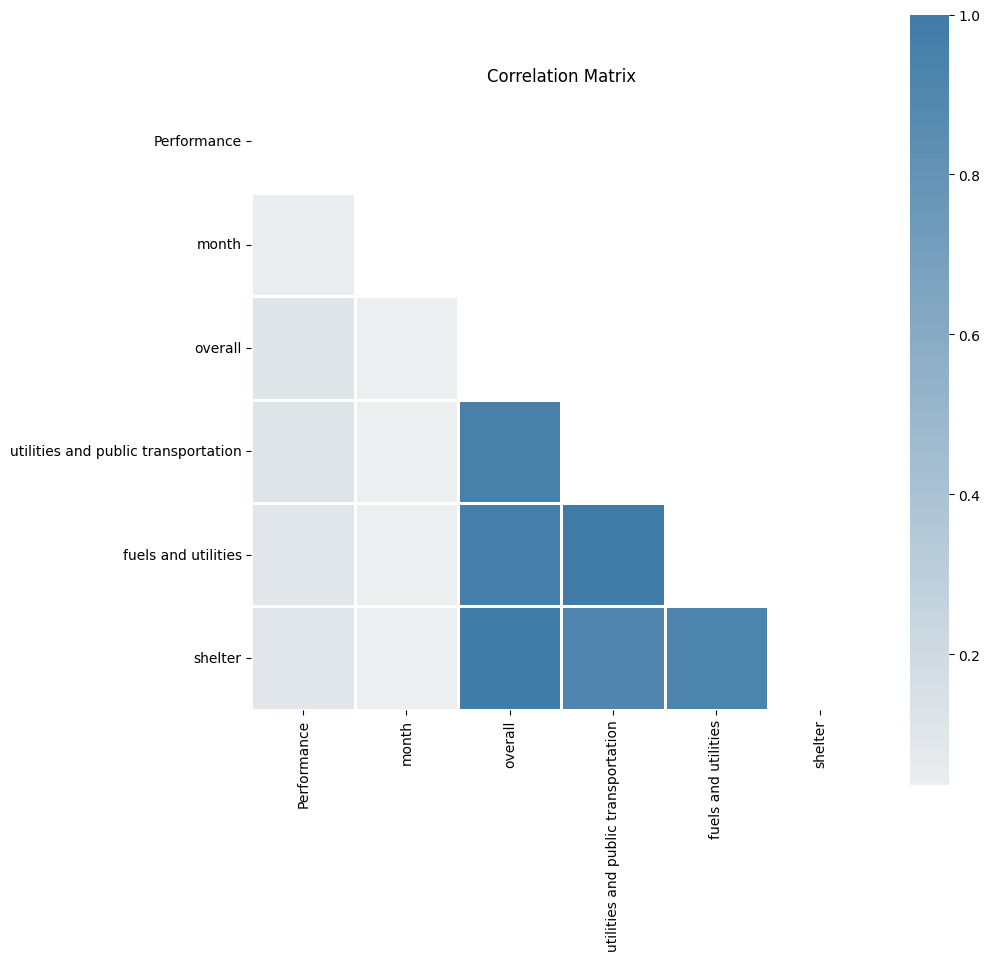

In [8]:
dd.correlation_matrix(original)

### Conditional GAN

In [9]:
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2015,3,3136.458552,305.787963,-2.364640,-1.354796,243.037091,211.896985,251.423981,290.146990,3
1,2020,3,1647.109428,281.110292,0.385121,-6.692102,232.440612,219.981858,240.451655,270.437618,3
2,2003,4,1389.215410,162.220220,-1.697148,2.216639,182.436908,164.310187,144.076255,219.682740,3
3,2020,4,1703.272943,294.754218,11.747908,-5.956163,241.620368,219.778058,234.255899,295.173579,3
4,1998,4,1299.729547,161.416854,3.229308,2.198433,183.747242,155.693130,147.670898,221.924255,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2018,3,1938.611298,277.834368,-0.086527,-7.842311,240.828757,220.306796,227.646961,303.951693,3
9996,2019,4,2659.434711,314.811455,9.362147,12.741277,233.759405,210.281594,215.206263,294.821755,3
9997,2014,4,1511.381384,222.473942,1.760055,0.606106,204.736446,195.133830,208.407274,225.531006,3
9998,2007,6,1294.877134,149.825221,1.038417,-4.202127,210.506246,181.269237,201.055264,206.999609,3


In [10]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)

In [11]:
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
samples.head()

,Performance,month,overall,utilities and public transportation,fuels and utilities,shelter
0,1,3,243.037091,211.896985,251.423981,290.146990
1,0,3,232.440612,219.981858,240.451655,270.437618
2,1,4,182.436908,164.310187,144.076255,219.682740
3,0,4,241.620368,219.778058,234.255899,295.173579
4,0,4,183.747242,155.693130,147.670898,221.924255


In [12]:
dd.data_summary(samples)

,Info
Rows,10000
Columns,6
Size in Memory,468.9 KB


,Data Type,Nulls,Zeros,Min,Median,Max,Mean,Standard Deviation,Unique,Top Frequency
Performance,int64,0,0,0,0,1,0.31,0.46,2,6928
month,int64,0,0,1,4,12,4.30,1.34,12,3621
overall,float64,0,0,162.22,218.63,285.33,216.24,26.40,10000,1
utilities and public transportation,float64,0,0,143.28,206.42,239.27,195.46,25.32,9999,2
fuels and utilities,float64,0,0,123.35,212.0065,272.11,201.28,36.58,10000,1
shelter,float64,0,0,181.64,250.97,362.52,255.41,39.56,10000,1


None

data-describe Summary Widget

<AxesSubplot: title={'center': 'Correlation Matrix'}>

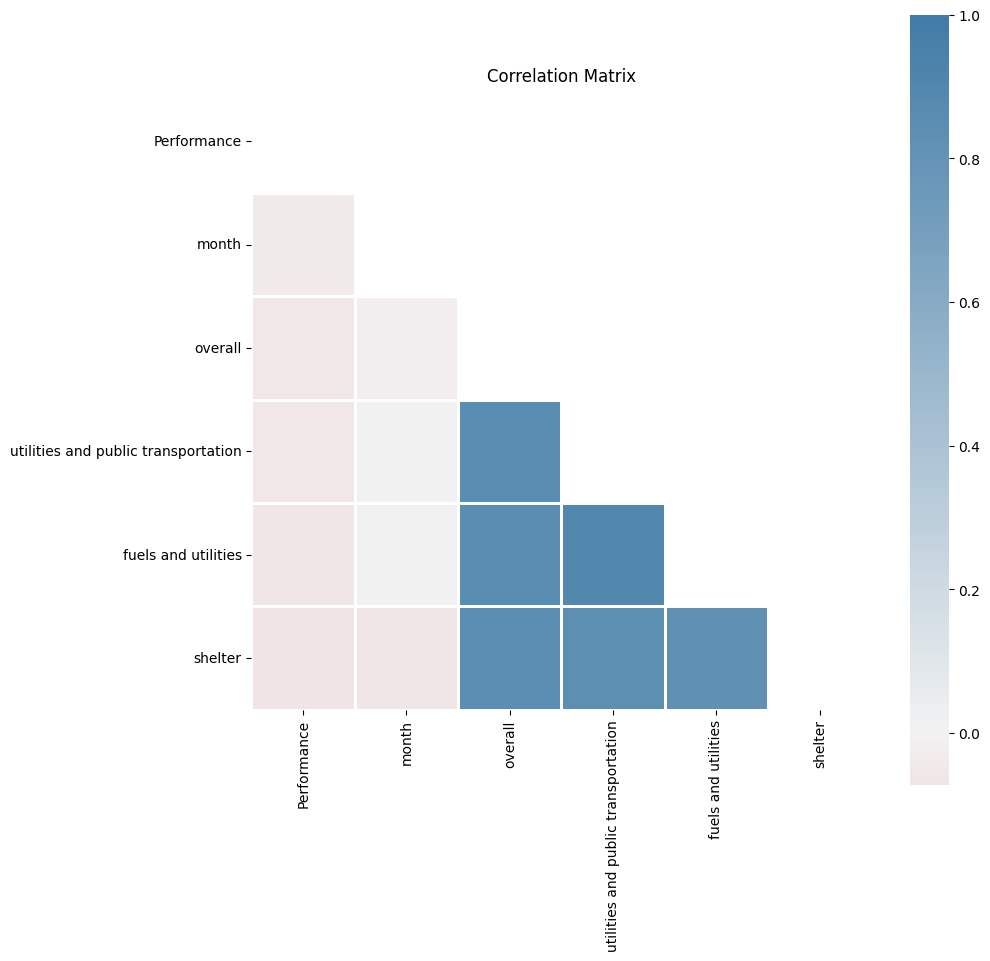

In [13]:
dd.correlation_matrix(samples)

In [14]:
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']

### SMOTE Oversampling

In [15]:
counter = Counter(y)
print(counter)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 6928, 1: 3072})
Counter({1: 6928, 0: 6928})


### Interaction Terms

In [16]:
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
X_poly

array([[  243.03709103,   211.89698507,   251.42398118, ...,
        53275.98358648, 61481.27235695, 72949.91129175],
       [  232.44061241,   219.98185769,   240.45165494, ...,
        52895.00173779, 59491.36957177, 65027.17277925],
       [  182.4369084 ,   164.31018747,   144.07625466, ...,
        23673.19641292, 36096.11223946, 31651.06643325],
       ...,
       [  217.46059916,   212.79079115,   208.44447696, ...,
        44355.06516336, 53661.34572043, 52565.29702688],
       [  235.35544047,   161.86549039,   217.32122744, ...,
        35176.80705125, 37108.90447253, 49822.55729412],
       [  237.90928694,   217.17625789,   237.53623221, ...,
        51587.23002523, 66339.11119244, 72558.31127293]])

In [17]:
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X.shape

(13856, 11)

In [18]:
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
X_real.shape

(263, 11)

In [19]:
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)

### Training with CV

In [20]:
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.676472,0.650536,0.751037,0.695767,0.655023,0.640062,0.714779,0.67536,0.490494,0.490196,0.378788,0.42735
1,DecisionTreeClassifier,0.669614,0.655213,0.708022,0.67923,0.653868,0.648189,0.679126,0.663297,0.467681,0.467742,0.439394,0.453125
2,RandomForestClassifier,0.761997,0.744095,0.790161,0.763893,0.735855,0.733825,0.743531,0.738646,0.498099,0.5,0.257576,0.34
3,AdaBoostClassifier,0.617939,0.608581,0.646531,0.625678,0.621536,0.611342,0.675676,0.641901,0.467681,0.465517,0.409091,0.435484
4,GradientBoostingClassifier,0.639158,0.628394,0.67006,0.64776,0.629908,0.62122,0.673376,0.646247,0.498099,0.5,0.295455,0.371429
5,ExtraTreesClassifier,0.788554,0.772219,0.813108,0.789789,0.758372,0.75509,0.767683,0.761334,0.479087,0.444444,0.151515,0.225989
6,BaggingClassifier,0.724395,0.733186,0.697348,0.71165,0.696882,0.71491,0.658999,0.685817,0.456274,0.41791,0.212121,0.281407
7,SVC,0.596644,0.587362,0.643928,0.613731,0.592379,0.586737,0.635998,0.610375,0.448669,0.421687,0.265152,0.325581
8,GaussianNB,0.5498,0.538796,0.690969,0.605418,0.549942,0.539753,0.702703,0.610542,0.452471,0.430233,0.280303,0.33945


### Voting Classifier

In [21]:
et_clf = ExtraTreesClassifier(random_state=random_state)
bag_clf = BaggingClassifier(random_state=random_state)
rf_clf = RandomForestClassifier(random_state=random_state)
classifiers = [('RF', rf_clf), \
               ('ET', et_clf),\
              ('Bagging', bag_clf)]

vc = VotingClassifier(estimators = classifiers, voting = 'soft')     
vc.fit(x_train, y_train)
y_pred = vc.predict(x_test)
vc_res = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F-1 Score'])
vc_res.loc[0, 'Accuracy'] = accuracy_score(y_test, y_pred)
vc_res.loc[0, 'Precision'] = precision_score(y_test, y_pred)
vc_res.loc[0, 'Recall'] = recall_score(y_test, y_pred)
vc_res.loc[0, 'F-1 Score'] = f1_score(y_test, y_pred)
vc_res

,Accuracy,Precision,Recall,F-1 Score
0,0.736143,0.729805,0.753306,0.74137


## Using all data

In [22]:
data = pd.read_csv('../data/S&P 500 Utilities 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
0,1993,5,1993-05-13,439.23,120.120003,-2.195551,-5.655040,UNDERPERFORM,144.300,134.700,121.400,155.800,3
1,1993,6,1993-06-10,445.38,121.970001,-2.363206,-5.981651,UNDERPERFORM,144.500,135.100,121.700,155.900,3
2,1993,7,1993-07-08,448.64,126.389999,-2.220866,-4.812472,UNDERPERFORM,144.800,135.700,122.100,156.200,3
3,1993,8,1993-08-12,448.96,129.559998,-3.088911,2.176652,OUTPERFORM,145.000,136.300,122.500,156.500,3
4,1993,9,1993-09-09,457.50,131.649994,-1.320047,9.808987,OUTPERFORM,145.600,136.300,122.600,156.900,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-2.530346,-2.112735,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-1.849766,1.229359,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-4.490556,3.558137,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,-7.366228,-6.053968,OUTPERFORM,278.524,232.450,271.467,340.475,3


In [23]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2009,8,1328.529718,169.213087,-5.129110,-6.245139,231.804174,183.976413,191.631001,235.494475,3
1,2014,8,2245.296885,194.229141,-4.903049,-5.626312,214.651259,207.224166,214.666875,251.285996,3
2,1994,8,1223.413000,85.732913,-2.670578,-3.968489,162.466714,152.888811,119.619671,168.854132,3
3,2017,6,2442.409271,204.418309,12.060035,4.493589,228.288204,211.185556,207.100169,243.466191,3
4,2017,10,2634.752135,235.651379,1.168942,-0.614765,245.805576,221.081195,236.014999,306.861038,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,1995,10,1014.874610,110.078924,-1.810126,-2.789500,152.011132,140.030597,126.000951,163.841344,3
9996,2004,10,1085.281497,191.611210,-4.285889,0.980878,165.906766,150.880642,225.681138,185.883305,3
9997,2009,8,1604.142661,192.935200,1.393786,2.608683,177.602646,192.630940,126.509456,224.590017,3
9998,2006,8,1369.754841,134.599101,-3.026559,-5.201175,174.989973,186.006920,202.979372,226.816015,3


In [24]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.661767,0.647233,0.706756,0.675002,0.646029,0.642012,0.673077,0.657177,0.51312,0.568493,0.44385,0.498498
1,DecisionTreeClassifier,0.668178,0.656223,0.699386,0.675421,0.650719,0.650823,0.662531,0.656625,0.507289,0.567164,0.406417,0.47352
2,RandomForestClassifier,0.740657,0.729513,0.760056,0.742783,0.725141,0.727216,0.727667,0.727442,0.460641,0.508333,0.326203,0.397394
3,AdaBoostClassifier,0.635027,0.649285,0.587655,0.616594,0.636023,0.654058,0.58995,0.620352,0.498542,0.582418,0.283422,0.381295
4,GradientBoostingClassifier,0.651994,0.654255,0.645189,0.64961,0.64853,0.655414,0.638337,0.646763,0.51895,0.594828,0.368984,0.455446
5,ExtraTreesClassifier,0.763487,0.751841,0.781942,0.764453,0.742339,0.742312,0.748759,0.745522,0.48105,0.546392,0.283422,0.373239
6,BaggingClassifier,0.71423,0.72419,0.687341,0.702679,0.69137,0.710722,0.653846,0.681099,0.472303,0.529412,0.28877,0.373702
7,SVC,0.626896,0.634391,0.598771,0.615652,0.625078,0.63981,0.586228,0.611848,0.533528,0.590604,0.470588,0.52381
8,GaussianNB,0.557076,0.560205,0.531664,0.545382,0.564415,0.571615,0.542184,0.556511,0.495627,0.54023,0.502674,0.520776


## Using data after 2010

In [25]:
data = pd.read_csv('../data/S&P 500 Utilities 50-Day.csv')
data.rename(columns={'Unnamed: 0':'date'}, inplace=True)
data = data.sort_values(by=['date'])
data = data.dropna()
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dow'] = data['date'].dt.dayofweek
data = data[data['dow']==3].groupby(['year','month']).nth[1].reset_index()
data = data[data['year'] >= 2010]
data

,year,month,date,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),S&P 500 Utilities (Sector) Outperform/Underperform,overall,utilities and public transportation,fuels and utilities,shelter,dow
200,2010,1,2010-01-14,1148.46,158.289993,-2.110431,4.543946,OUTPERFORM,217.281,201.045,212.638,247.997,3
201,2010,2,2010-02-11,1078.47,146.449997,-11.020997,-5.473437,OUTPERFORM,217.353,202.330,214.506,247.914,3
202,2010,3,2010-03-11,1150.24,151.440002,5.750719,4.766516,UNDERPERFORM,217.403,202.917,214.821,247.959,3
203,2010,4,2010-04-08,1186.44,152.529999,6.168177,-0.300677,UNDERPERFORM,217.290,203.124,214.303,248.128,3
204,2010,5,2010-05-13,1157.44,152.580002,3.805347,-2.091885,UNDERPERFORM,217.199,203.501,213.427,248.295,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2021,7,2021-07-08,4320.82,328.029999,-2.530346,-2.112735,OUTPERFORM,273.092,229.005,262.483,335.888,3
339,2021,8,2021-08-12,4460.83,345.839996,-1.849766,1.229359,OUTPERFORM,274.214,229.123,265.333,337.298,3
340,2021,9,2021-09-09,4493.28,350.709991,-4.490556,3.558137,OUTPERFORM,276.590,231.525,270.870,338.865,3
341,2021,10,2021-10-14,4438.26,334.570007,-7.366228,-6.053968,OUTPERFORM,278.524,232.450,271.467,340.475,3


In [26]:
original = data[['S&P 500 Utilities (Sector) Outperform/Underperform','month','overall',\
                                                         'utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
data.drop(columns=['date','S&P 500 Utilities (Sector) Outperform/Underperform'], inplace=True)
original['Performance'] = np.where(original['S&P 500 Utilities (Sector) Outperform/Underperform'] == 'OUTPERFORM',1,0)
original = original[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
discrete_columns = [
    'month'
]

ctgan = CTGAN(epochs=5000)
ctgan.fit(data, discrete_columns)

# Synthetic copy
samples = ctgan.sample(10000)
samples

,year,month,S&P 500,S&P 500 Utilities (Sector),S&P 500 Performance (%),S&P 500 Utilities (Sector) Performance (%),overall,utilities and public transportation,fuels and utilities,shelter,dow
0,2010,4,1104.940648,170.025558,2.465380,2.798452,220.264706,205.585071,215.458946,237.801752,3
1,2014,2,2935.299110,305.948037,-4.394166,-3.777295,256.328679,217.202090,241.474988,273.315750,3
2,2008,3,1576.259576,208.137305,-3.629285,-3.484856,223.850612,202.887448,213.267790,234.784432,3
3,2019,2,2575.037428,271.485827,-7.415553,-12.484103,248.970308,218.675925,244.213412,306.970000,3
4,2019,2,3790.158264,313.862617,-3.770136,-1.389398,269.954804,228.029563,251.591445,337.782001,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,2013,2,1490.027785,165.475358,-5.106172,-6.294637,230.973348,209.358026,220.902739,264.741807,3
9996,2016,2,1305.092341,150.295297,-3.001233,1.715854,232.884477,205.939295,222.206191,275.675672,3
9997,2011,4,1623.165214,216.985051,-1.866064,-4.921968,228.317593,204.425655,218.527171,252.165609,3
9998,2009,2,1175.127676,200.537970,1.899202,2.246570,221.712660,203.667948,212.054230,249.060954,3


In [27]:
samples['Performance'] = np.where(samples['S&P 500 Utilities (Sector) Performance (%)'] > \
                                  samples['S&P 500 Performance (%)'], 1, 0)
samples = samples[['Performance','month','overall','utilities and public transportation',\
                                                             'fuels and utilities','shelter']]
X = samples.drop(['Performance'],axis=1)
y = samples['Performance']
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_poly = poly.fit_transform(X.drop(['month'],axis=1))
month = X['month'].to_numpy()
month = np.reshape(month,(-1,1))
X = np.append(X_poly,month,1)
X_real = original.drop(['Performance'],axis=1)
y_real = original['Performance']
X_real_poly = poly.fit_transform(X_real.drop(['month'],axis=1))
month = X_real['month'].to_numpy()
month = np.reshape(month,(-1,1))
X_real = np.append(X_real_poly,month,1)
stscaler = StandardScaler().fit(X)
X = stscaler.transform(X)
X_real = stscaler.transform(X_real)
random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)
classifiers = []

classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(GaussianNB())

k_fold = StratifiedKFold(n_splits=10)

Model_Comparison = pd.DataFrame(columns=['Name', 'CV Mean Accuracy', 'CV Mean Precision', 'CV Mean Recall',\
                                         'CV Mean F-1 Score', \
                                         'Accuracy', 'Precision', 'Recall', 'F-1 Score',\
                                        'Accuracy Real', 'Precision Real', 'Recall Real', 'F-1 Score Real'])
row = 0
for clf in classifiers:
    name = clf.__class__.__name__
    Model_Comparison.loc[row, 'Name'] = name
    
    Model_Comparison.loc[row, 'CV Mean Accuracy'] = cross_val_score(clf, X, y, scoring = 'accuracy', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Precision'] = cross_val_score(clf, X, y, scoring = 'precision',\
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean Recall'] = cross_val_score(clf, X, y, scoring = 'recall', \
                                                                 cv = k_fold, n_jobs = 10).mean()
    Model_Comparison.loc[row, 'CV Mean F-1 Score'] = cross_val_score(clf, X, y, scoring = 'f1', \
                                                                 cv = k_fold, n_jobs = 10).mean()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    Model_Comparison.loc[row, 'Accuracy'] = accuracy_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Precision'] = precision_score(y_test, y_pred)
    Model_Comparison.loc[row, 'Recall'] = recall_score(y_test, y_pred)
    Model_Comparison.loc[row, 'F-1 Score'] = f1_score(y_test, y_pred)
    
    y_pred = clf.predict(X_real)
    Model_Comparison.loc[row, 'Accuracy Real'] = accuracy_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Precision Real'] = precision_score(y_real, y_pred)
    Model_Comparison.loc[row, 'Recall Real'] = recall_score(y_real, y_pred)
    Model_Comparison.loc[row, 'F-1 Score Real'] = f1_score(y_real, y_pred)
    
    row += 1
Model_Comparison

,Name,CV Mean Accuracy,CV Mean Precision,CV Mean Recall,CV Mean F-1 Score,Accuracy,Precision,Recall,F-1 Score,Accuracy Real,Precision Real,Recall Real,F-1 Score Real
0,KNeighborsClassifier,0.580766,0.585959,0.563505,0.573758,0.589626,0.600482,0.563348,0.581323,0.552448,0.616438,0.555556,0.584416
1,DecisionTreeClassifier,0.563318,0.567085,0.557775,0.56146,0.568268,0.576498,0.551282,0.563608,0.566434,0.641791,0.530864,0.581081
2,RandomForestClassifier,0.606416,0.620652,0.571884,0.593285,0.592677,0.606436,0.554299,0.579196,0.629371,0.684211,0.641975,0.66242
3,AdaBoostClassifier,0.604693,0.610975,0.575524,0.592483,0.598017,0.610569,0.566365,0.587637,0.594406,0.626374,0.703704,0.662791
4,GradientBoostingClassifier,0.619473,0.633932,0.565408,0.597588,0.611365,0.635004,0.544495,0.586277,0.545455,0.614286,0.530864,0.569536
5,ExtraTreesClassifier,0.604511,0.618784,0.579326,0.595731,0.602593,0.616393,0.567119,0.590731,0.545455,0.595238,0.617284,0.606061
6,BaggingClassifier,0.58496,0.609202,0.492176,0.543017,0.575133,0.600952,0.475867,0.531145,0.524476,0.589041,0.530864,0.558442
7,SVC,0.600878,0.630745,0.486649,0.549243,0.590389,0.626,0.472097,0.538263,0.58042,0.684211,0.481481,0.565217
8,GaussianNB,0.522215,0.528494,0.413226,0.463522,0.512204,0.525516,0.365008,0.430797,0.552448,0.616438,0.555556,0.584416
